# 20. Segmentation map으로 도로 이미지 만들기

## 노드 정리
### pix2pix
Pix2Pix는 입력 이미지를 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN모델이다. Pix2Pix를 제안한 논문 [ Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/pdf/1611.07004.pdf)은 Conditional Adversarial Networks로 이미지 간 변환(Image-to-Image Translation)을 한 결과를 담고 있다. 한 이미지의 픽셀에서 다른 이미지의 픽셀로 변환한다는 뜻에서 Pix2Pix라고 불린다. 이미지 변환이 목적인 Pix2Pix는 이미지를 다루는데 효율적인 Convolution 레이어를 활용하며, GAN 구조를 기반으로 하기 때문에 Generator와 Discriminator로 이루어져 있다.  

#### Generator          
Generator는 이미지를 입력받아 변환된 이미지를 출력한다. 입력 이미지와 변환된 이미지의 크기는 동일하며 흔히 사용되는 구조는 Encoder-Decoder 구조이다. Encoder에서 입력이미지를 받으면 이미지를 단계적으로 down-sampling하면서 입력 이미지의 중요한 representation을 학습하고 Decoder에서는 반대로 이미지를 up-sampling하여 입력 이미지와 동일한 크기의 변환된 이미지를 생성한다. 

이 과정은 모두 convolution 레이어로 진행되고, 레이어 내의 수많은 파라미터를 학습해 잘 변환된 이미지를 얻도록 한다. Encoder와 Decoder 사이의 작은 사각형은 bottleneck이라고 불리며 입력 이미지의 가장 중요한 특징만 답고 있다. 

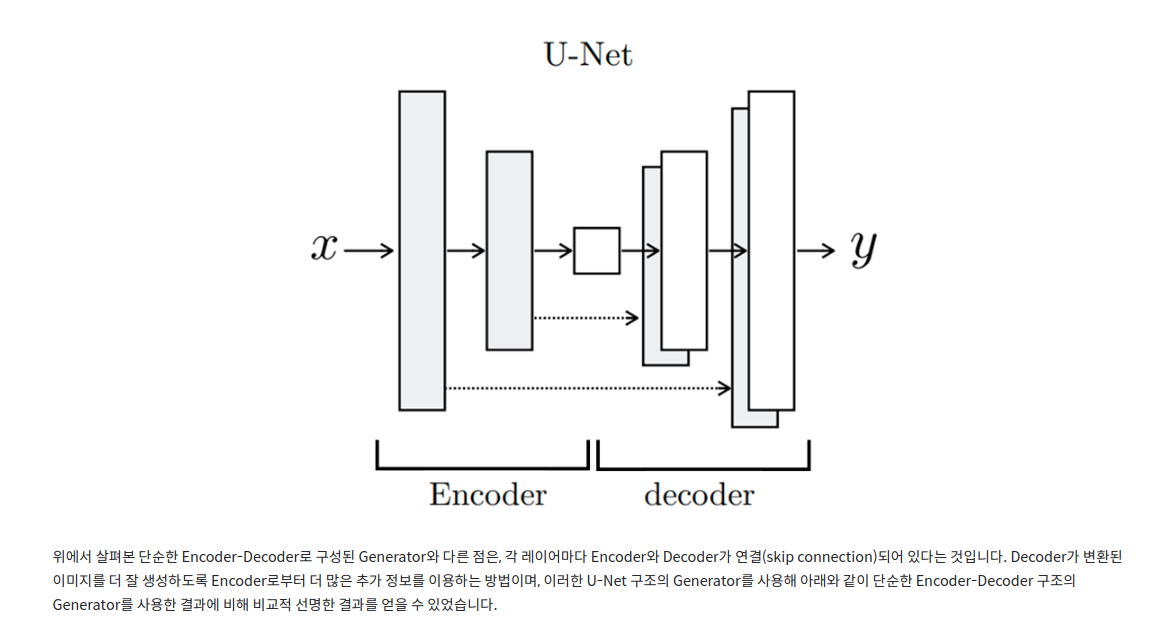

Pix2Pix는 각 레이어마다 Encoder와 Decoder를 연결(skip connection)하여 Encoder로부터 추가 정보를 제공받아 Decoder가 변환된 이미지를 잘 생성하도록 한다. 이런 구조를 U-Net 구조라고 한다. U-Net 구조를 사용한 Generator는 일반적인 Encoder-Decoder 구조를 사용한 것보다 선명한 결과를 얻을 수 있다.

#### Loss Function

#### Discriminator
Pix2Pix는 하나의 전체 이미지로부터 하나의 확률값을 도출하여 진짜 혹은 가짜를 판단했던 DCGAN과 다른 Discriminator를 사용한다.

![](https://images.velog.io/images/guide333/post/fb56b372-6bbc-4985-9f1c-2eae8ce39f29/Screenshot%20from%202021-03-23%2001-33-43.png)

하나의 이미지가 Discriminator의 입력으로 들어오면 convolution 레이러를 거쳐 여려 개의 확률값을 갖게 된다. 위의 그림에서 입력 이미지의 파란 점선은 여러 출력 중 하나의 출력을 계산하기 위한 입력 이미지의 receptive field 영역이며, 일부의 영역(파란 점선)에 대해서만 진짜/가짜를 판별하는 하나의 확률값을 도출한다. 이런 방식으로 서로 다른 영역에 대해 진짜/가자를 나타내는 여러 개의 확률값을 계산하고, 이 값을 평균내어 최종 Discriminator의 출력을 생성한다. 이런 방법을 PatchGAN이라고 부른다. 일반적으로 거리가 먼 두 픽셀은 서로 연관성이 없으므로 일부 영역에 대해서 세부적으로 진짜/가짜를 판별하는 것이 Generator로 하여금 더 진짜같은 이미지를 만들도록 한다. 

## 프로젝트 순서
1. 데이터 준비하기
2. Generator 구성하기
3. Discriminator 구성하기
4. 학습 및 테스트
5. 시각화
6. 다양한 augmentation 시도하기 

## 프로젝트 가이드

이번 프로젝트는 cityscapes.zip을 이용해 Pix2Pix를 학습시켜보는 것입니다. 데이터셋은 1000개의 학습용 이미지 및 5개의 평가 이미지를 포함합니다.

이전 포켓몬 데이터에서 사용했던 스케치와는 조금 다른 레이블 정보 이미지를 입력으로 사용하기 때문에, 전처리 과정에 대해 약간의 혼란이 있을 수 있지만 크게 다른 과정은 없습니다.
아래 Tensroflow에서 제공하는 Pix2Pix 튜토리얼은 위 이미지와 비슷한 레이블 정보 이미지를 사용하기 때문에 좋은 참고 자료가 될 수 있을 것 같습니다.

프로젝트 시작에 어려움이 있다면 [튜토리얼](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko)을 참고하시면서 이번 프로젝트를 수행해봅시다.
(아래 튜토리얼은 Pix2Pix 구조를 Functional API를 이용해 구현하기 때문에 이번에 진행한 Subclassing 방법을 이용한 모델 구현과 비교하면서 구현 방법에 대해서도 공부해 보시길 추천드립니다)

## 프로젝트 수행
프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요.(어떠한 방법을 사용했는지 적어주세요.)
2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.
3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.
5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

### 데이터 준비하기

In [2]:
# 라이브러리 가져오기

import tensorflow as tf
import os
import time
import numpy as np
import cv2

from matplotlib import pyplot as plt
from IPython import display

In [3]:
image_path = os.getenv('HOME') + '/aiffel/conditional_generation/cityscapes/'
train = image_path + 'train/'
val = image_path + 'val/'
print(f'the number of train examples: {len(os.listdir(train))}')
print(f'the number of val examples: {len(os.listdir(val))}')

the number of train examples: 1000
the number of val examples: 5


총 1000개의 학습용 데이터와 5개의 검증용 데이터가 존재한다. 학습용 데이터에서 임의로 6장을 선택해 시각화한다.

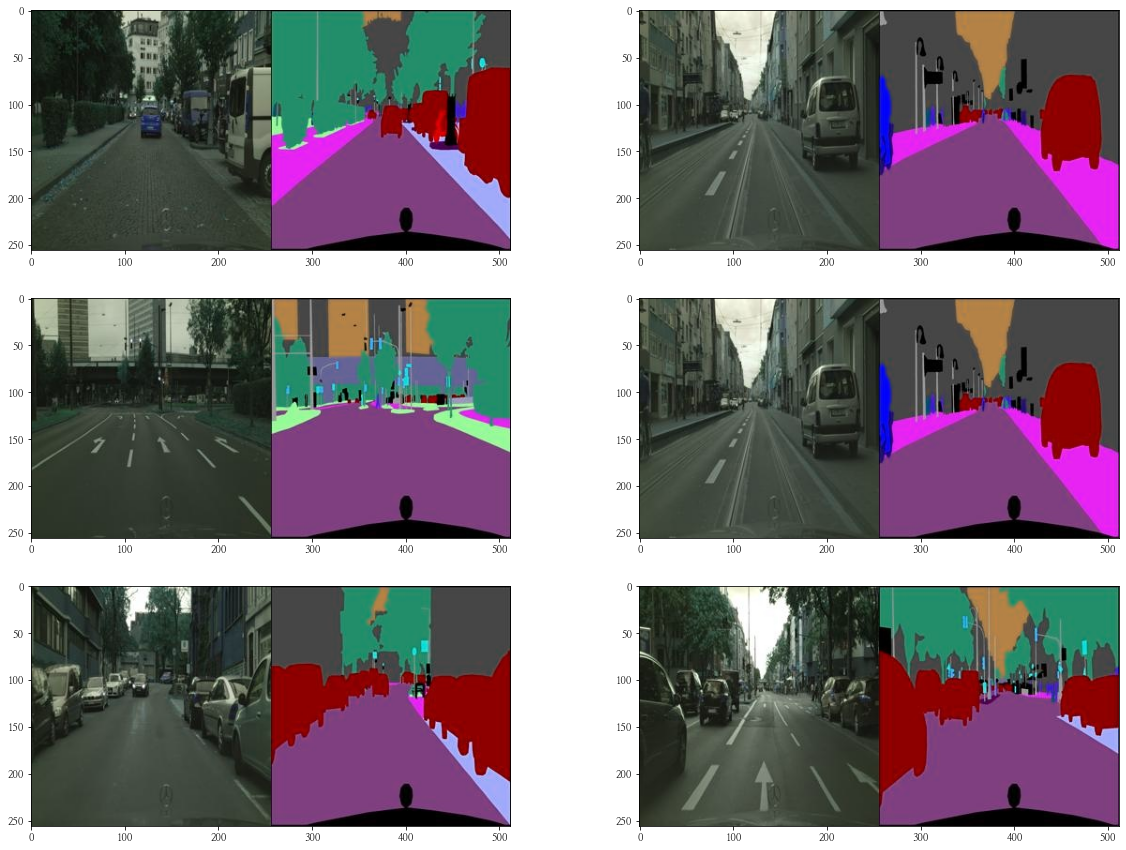

In [4]:
plt.figure(figsize=(20,15))

for i in range(1, 7):
    f = train + os.listdir(train)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

이미지를 하나 열어 아래와 같이 크기를 확인한다. 

In [5]:
f = train + os.listdir(train)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


위의 이미지는 2개의 이미지가 합쳐져 있으므로 2개의 이미지로 분할하여 사용한다.

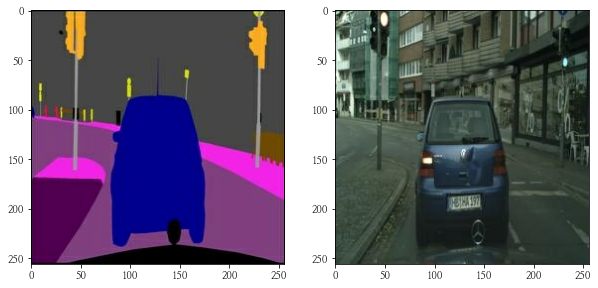

In [6]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    segment = img[:, :w, :] 
    segment = tf.cast(segment, tf.float32)
    city = img[:, w:, :] 
    city = tf.cast(city, tf.float32)
    return normalize(segment), normalize(city)

f = train + os.listdir(train)[1]
city, segment = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(segment))
plt.subplot(1,2,2); plt.imshow(denormalize(city))

2개의 이미지로 나누었다. 첫번째 이미지 segment를 pix2pix 모델에 입력해 두 번째 이미지와 같은 이미지를 생성하는 것이 목표이다. 학습에 사용할 수 있는 데이터의 수는 1000개 이므로 학습 데이터의 다양성을 위해 여러 augmentation 방법을 적용한다.

- 1. 노드에서 사용한 augmentation
   1. 두 이미지를 채널축으로 연결한다.
   2. A의 결과에 50% 확률로 reflecting padding 또는 constant padding이 30픽셀의 pad width만큼 적용한다. (tf.pad)
   3. B.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 자른다.(tf.image.random_crop)
   4. C.의 결과를 50% 확률로 가로로 뒤집는다. (tf.image.random_flip_left_right)
   5. D.의 결과를 50% 확률로 세로로 뒤집는다. (tf.image.random_flip_up_down) 
   6. E.의 결과를 50% 확률로 회전시킨다. (tf.image.rot90)

In [6]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(segment, city):
    stacked = tf.concat([segment, city], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

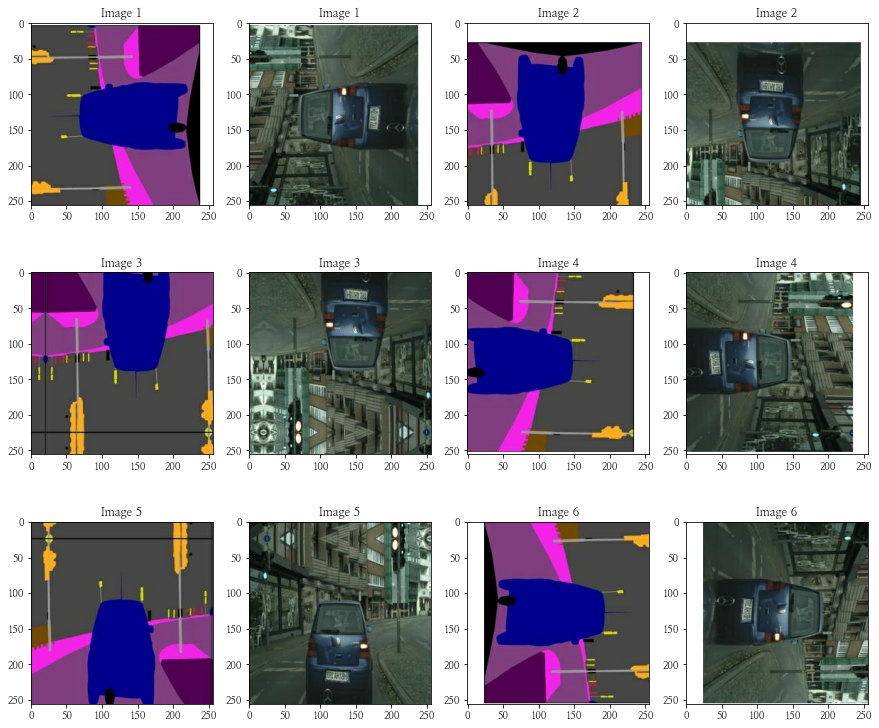

In [7]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_segment, augmented_city = apply_augmentation(segment, city)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_segment)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_city)); plt.title(f"Image {img_n}")
    img_n += 1

위의 과정을 학습 데이터에 적용하여 잘 적용되었는지 확인해본다.

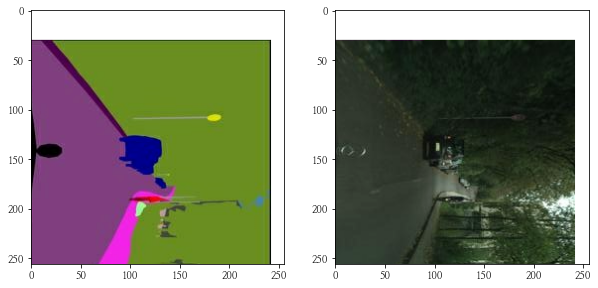

In [8]:
from tensorflow import data

def get_train(img_path):
    segment, city = load_img(img_path)
    segment, city = apply_augmentation(segment, city)
    return city, segment

train_images = data.Dataset.list_files(train + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
segment, city = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(segment[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(city[0].astype(np.uint8))

### Generator 구성하기

Generator의 Encoder부분과 Decoder부분을 구현한다.

In [9]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [10]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

- call() 내에서 ' features = features[:-1]'    
Skip connection을 위해 만들어진 features 리스트에는 Encoder 내 각 블록의 출력이 들어있다. Encoder의 마지막 출력(feature리스트 의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아니기 때문에 마지막 항목은 제외한다.
- call() 내의 Decoder 연산 부분에서 features[::-1]    
Skip connection은 Encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고, Encoder 내 두 번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는 식으로 대칭을 이룬다. features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 이를 Decoder에서 차례대로 사용하기 위해서 features의 역순으로 연결해야 한다.
- layers.Concatenate() 내에 별다른 설정이 없다면 가장 마지막 축(채널 축)을 기준으로 서로 연결된다.   
concat((32,128,128,200), (32,128,128,400)) - > (128,128,600)    

In [11]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

### Discriminator 구성하기

In [12]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [13]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [14]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

### 학습 및  테스트
레이블 정보만 있는 입력에 대해 여러 손실함수를 사용해 실제 이미지를 만든 결과는 일반적인 GAN의 손실함수에 L1을 추가로 사용했을 때 가장 실제에 가까운 이미지를 생성했으므로 이 프로젝트에서도 두 손실함수를 모두 사용한다.

- Generator의 손실함수 (위 코드의 get_gene_loss)는 총 3개의 입력이 있다.     
  - fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용한다. 
  - L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산한다.

- Discriminator의 손실함수 (위 코드의 get_disc_loss)는 2개의 입력이 있으며, 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값이다. 
  - Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교한다.

In [15]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


In [16]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)


- 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정    
  - Generator의 손실 정의   
![](https://images.velog.io/images/guide333/post/be834e66-62fe-42d2-b7bd-052c2c4ca7eb/Screenshot%20from%202021-03-23%2002-03-30.png)

In [17]:
@tf.function
def train_step(segment, real_city):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_city = generator(segment, training=True)
        # Discriminator 예측
        fake_disc = discriminator(segment, fake_city, training=True)
        real_disc = discriminator(segment, real_city, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_city, real_city, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [18]:
EPOCHS = 200

generator = UNetGenerator()
discriminator = Discriminator()

history =  {'g_loss':[], 'L1_loss':[], 'd_loss':[]}

for epoch in range(1, EPOCHS+1):
    for i, (segment, city) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segment, city)
        history['g_loss'].append(g_loss)
        history['L1_loss'].append(l1_loss)
        history['d_loss'].append(d_loss)
                        
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[100]                     
Generator_loss:1.1645                     
L1_loss:0.1691                     
Discriminator_loss:1.0247

EPOCH[1] - STEP[200]                     
Generator_loss:1.4070                     
L1_loss:0.1991                     
Discriminator_loss:0.5184

EPOCH[2] - STEP[100]                     
Generator_loss:2.2171                     
L1_loss:0.1991                     
Discriminator_loss:0.5896

EPOCH[2] - STEP[200]                     
Generator_loss:1.7681                     
L1_loss:0.1857                     
Discriminator_loss:0.7513

EPOCH[3] - STEP[100]                     
Generator_loss:1.0865                     
L1_loss:0.1758                     
Discriminator_loss:0.6539

EPOCH[3] - STEP[200]                     
Generator_loss:1.3742                     
L1_loss:0.2064                     
Discriminator_loss:0.5313

EPOCH[4] - STEP[100]                     
Generator_loss:2.3836                     
L1_loss:0.1628             

EPOCH[29] - STEP[100]                     
Generator_loss:1.1236                     
L1_loss:0.1604                     
Discriminator_loss:0.7575

EPOCH[29] - STEP[200]                     
Generator_loss:2.1009                     
L1_loss:0.1647                     
Discriminator_loss:0.5641

EPOCH[30] - STEP[100]                     
Generator_loss:1.7265                     
L1_loss:0.1507                     
Discriminator_loss:0.7515

EPOCH[30] - STEP[200]                     
Generator_loss:2.5327                     
L1_loss:0.1589                     
Discriminator_loss:2.3157

EPOCH[31] - STEP[100]                     
Generator_loss:0.8009                     
L1_loss:0.1548                     
Discriminator_loss:0.8214

EPOCH[31] - STEP[200]                     
Generator_loss:1.8489                     
L1_loss:0.1670                     
Discriminator_loss:0.9971

EPOCH[32] - STEP[100]                     
Generator_loss:2.5456                     
L1_loss:0.1568      

EPOCH[56] - STEP[200]                     
Generator_loss:0.9830                     
L1_loss:0.2077                     
Discriminator_loss:0.5915

EPOCH[57] - STEP[100]                     
Generator_loss:1.2081                     
L1_loss:0.1747                     
Discriminator_loss:0.6548

EPOCH[57] - STEP[200]                     
Generator_loss:2.1264                     
L1_loss:0.1781                     
Discriminator_loss:0.3187

EPOCH[58] - STEP[100]                     
Generator_loss:1.4055                     
L1_loss:0.1852                     
Discriminator_loss:0.5064

EPOCH[58] - STEP[200]                     
Generator_loss:0.7777                     
L1_loss:0.1617                     
Discriminator_loss:0.8118

EPOCH[59] - STEP[100]                     
Generator_loss:1.1196                     
L1_loss:0.1668                     
Discriminator_loss:1.6147

EPOCH[59] - STEP[200]                     
Generator_loss:0.6604                     
L1_loss:0.1706      

EPOCH[84] - STEP[100]                     
Generator_loss:1.0603                     
L1_loss:0.1658                     
Discriminator_loss:0.7101

EPOCH[84] - STEP[200]                     
Generator_loss:1.1518                     
L1_loss:0.1529                     
Discriminator_loss:0.9263

EPOCH[85] - STEP[100]                     
Generator_loss:1.8742                     
L1_loss:0.1784                     
Discriminator_loss:1.4882

EPOCH[85] - STEP[200]                     
Generator_loss:2.2603                     
L1_loss:0.1634                     
Discriminator_loss:0.6079

EPOCH[86] - STEP[100]                     
Generator_loss:0.9355                     
L1_loss:0.1686                     
Discriminator_loss:1.2068

EPOCH[86] - STEP[200]                     
Generator_loss:0.7543                     
L1_loss:0.1802                     
Discriminator_loss:0.7126

EPOCH[87] - STEP[100]                     
Generator_loss:1.3297                     
L1_loss:0.1799      

EPOCH[111] - STEP[200]                     
Generator_loss:1.8764                     
L1_loss:0.1417                     
Discriminator_loss:1.8390

EPOCH[112] - STEP[100]                     
Generator_loss:1.2947                     
L1_loss:0.1593                     
Discriminator_loss:1.4051

EPOCH[112] - STEP[200]                     
Generator_loss:1.0728                     
L1_loss:0.1729                     
Discriminator_loss:0.7008

EPOCH[113] - STEP[100]                     
Generator_loss:0.9384                     
L1_loss:0.1551                     
Discriminator_loss:0.9990

EPOCH[113] - STEP[200]                     
Generator_loss:1.9398                     
L1_loss:0.1746                     
Discriminator_loss:3.0117

EPOCH[114] - STEP[100]                     
Generator_loss:1.2064                     
L1_loss:0.1508                     
Discriminator_loss:0.8163

EPOCH[114] - STEP[200]                     
Generator_loss:1.1626                     
L1_loss:0.156

EPOCH[139] - STEP[100]                     
Generator_loss:1.7647                     
L1_loss:0.1646                     
Discriminator_loss:0.7635

EPOCH[139] - STEP[200]                     
Generator_loss:1.1638                     
L1_loss:0.1727                     
Discriminator_loss:0.6511

EPOCH[140] - STEP[100]                     
Generator_loss:1.0089                     
L1_loss:0.1839                     
Discriminator_loss:0.6793

EPOCH[140] - STEP[200]                     
Generator_loss:0.8602                     
L1_loss:0.1431                     
Discriminator_loss:1.1066

EPOCH[141] - STEP[100]                     
Generator_loss:0.7420                     
L1_loss:0.1681                     
Discriminator_loss:0.7714

EPOCH[141] - STEP[200]                     
Generator_loss:1.9853                     
L1_loss:0.1990                     
Discriminator_loss:0.3705

EPOCH[142] - STEP[100]                     
Generator_loss:1.4822                     
L1_loss:0.168

EPOCH[166] - STEP[200]                     
Generator_loss:1.4900                     
L1_loss:0.1482                     
Discriminator_loss:0.6368

EPOCH[167] - STEP[100]                     
Generator_loss:1.0311                     
L1_loss:0.1373                     
Discriminator_loss:1.7341

EPOCH[167] - STEP[200]                     
Generator_loss:1.6907                     
L1_loss:0.1726                     
Discriminator_loss:0.6029

EPOCH[168] - STEP[100]                     
Generator_loss:1.5104                     
L1_loss:0.1602                     
Discriminator_loss:1.0605

EPOCH[168] - STEP[200]                     
Generator_loss:0.7676                     
L1_loss:0.1980                     
Discriminator_loss:0.9780

EPOCH[169] - STEP[100]                     
Generator_loss:1.0475                     
L1_loss:0.1344                     
Discriminator_loss:1.3282

EPOCH[169] - STEP[200]                     
Generator_loss:1.1734                     
L1_loss:0.149

EPOCH[194] - STEP[100]                     
Generator_loss:1.6867                     
L1_loss:0.1514                     
Discriminator_loss:0.9262

EPOCH[194] - STEP[200]                     
Generator_loss:1.3343                     
L1_loss:0.1591                     
Discriminator_loss:1.3108

EPOCH[195] - STEP[100]                     
Generator_loss:1.5177                     
L1_loss:0.1630                     
Discriminator_loss:1.2053

EPOCH[195] - STEP[200]                     
Generator_loss:2.6872                     
L1_loss:0.1598                     
Discriminator_loss:1.0191

EPOCH[196] - STEP[100]                     
Generator_loss:1.0678                     
L1_loss:0.1710                     
Discriminator_loss:0.5959

EPOCH[196] - STEP[200]                     
Generator_loss:1.6910                     
L1_loss:0.1530                     
Discriminator_loss:0.8055

EPOCH[197] - STEP[100]                     
Generator_loss:0.9855                     
L1_loss:0.147

### 시각화

Text(0.5, 1.0, 'Ground Truth')

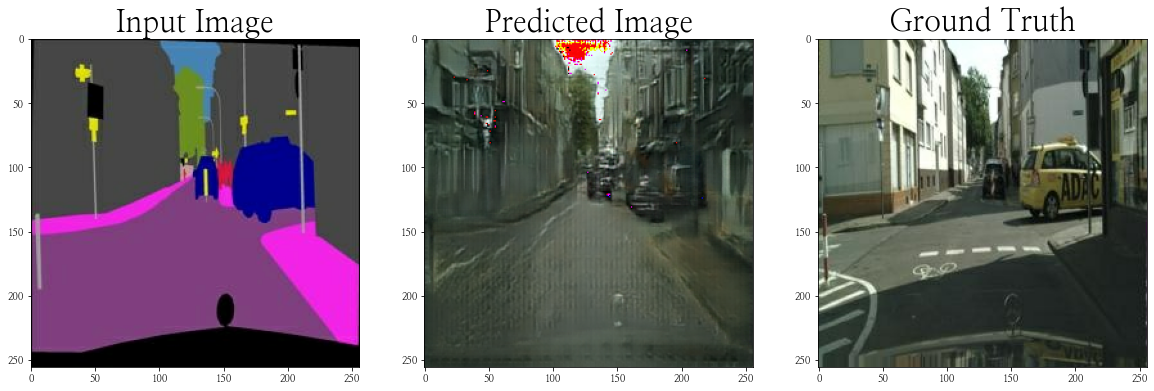

In [19]:
test_ind = 1

f = val + os.listdir(val)[test_ind]
city, segment = load_img(f)

pred = generator(tf.expand_dims(segment, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(denormalize(segment))
plt.title("Input Image", fontsize=30)
plt.subplot(1,3,2)
plt.imshow(pred[0])
plt.title("Predicted Image", fontsize=30)
plt.subplot(1,3,3)
plt.imshow(denormalize(city))
plt.title("Ground Truth", fontsize=30)

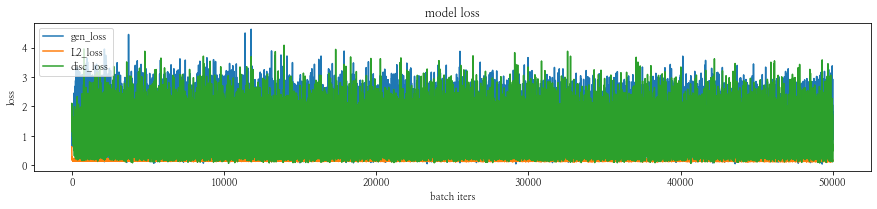

In [20]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.
        # summarize history for loss  
plt.subplot(211)  
plt.plot(history['g_loss']) 
plt.plot(history['L1_loss'])
plt.plot(history['d_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.legend(['gen_loss', 'L2_loss', 'disc_loss'], loc='upper left')  

plt.show()

## 루브릭
|평가문항|	상세기준|결과|
|:------:|:--------:|:---:|
|1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.|데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.|?  |
|2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.|U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.|Y  |
|3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.|10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.| Y    |

## 후기
### 이번 프로젝트에서 어려웠던 점
- 변수 설정 -  노드와 달리 이미지 변수를 설정을 잘못 했더니 이미지가 제대로 생성되지 않았다. 몇 번의 시행착오 끝에 이미지가 생성된 것 같다.
- 다양한 augmentation -  albumentations나 Imagegenerator 등을 시도하였지만 이미지를 불러오는 방법을 몰라서 성공하지 못하였다.

### 프로젝트를 진행하면서 알게된 점
- U-Net과 pix2pix의 개념

### 프로젝트를 진행하면서 아직 모호한 점
- 이미지의 형태
- 이론과 코드와의 연관성을 제대로 파악하지 못했다.

### 자기 다짐
마지막 프로젝트를 하면서 많은 생각이 들었다. 20개의 프로젝트를 하면서도 모델과 코드에 대해 여전히 제대로 이해하고 있지 못 하고 있음을 깨달았다. image augmentation 같이 혼자서 공부한 내용을 소화하여 프로젝트에 적용하는 것이 쉽지 않고, 노드의 내용도 다른 것에 적용하는 것도 어렵다. 더 열심히 해야겠다는 생각이 든다. 